# <center> TUTORIAL <center>
# <center> _Training and validating CLASTER_ <center>

*Authors:* 

Marc Pielies Avelli ([marc.pielies-avelli@cpr.ku.dk](mailto:marc.pielies-avelli@cpr.ku.dk), [mpielies@broadinstitute.org](mailto:mpielies@broadinstitute.org) )

Arnor Sigurdsson ([arnor.sigurdsson@sund.ku.dk](mailto:arnor.sigurdsson@sund.ku.dk), [asigurds@broadinstitute.org](mailto:asigurds@broadinstitute.org))

Henry Webel ([henry.webel@sund.ku.dk](mailto:henry.webel@sund.ku.dk))
 
Simon Rasmussen ([srasmuss@sund.ku.dk](mailto:srasmuss@sund.ku.dk), [srasmuss@broadinstitute.org](mailto:srasmuss@broadinstitute.org))

## Introduction ##

Hi! 

Welcome to this small tutorial on how to build and run CLASTER using the EIR framework. Please clone this repository (CLASTER) on your computer to start.

### About CLASTER

The Chromatin Landscape and Structure Expression Regressor (CLASTER) is a deep convolutional neural network aimed to translate a given chromatin landscape and its matching 3D structure to the corresponding nascent RNA landscape. 

<p align="center">
<img src="../images/Claster_image.png" alt="Claster image" width="600"/>
</p>

**Figure 1. Network overview.** *Chromatin landscape information is provided as ATAC-seq, H3K4me3 (promoter), H3K27ac (enhancer) and H3K27me3 (silencer) enrichment levels for a region of 1Mbp at a resolution of 100bp. Chromatin structure is provided as a Micro-C map matching the genomic region covered by the other branch of the model at a resolution of 1600kbp. A set of convolutions extract features from both branches separately, then these features are combined in a set of fully connected layers (MLP) and finally used to predict the nascent transcription profiles (measured by EU-seq) at a kbp resolution.*  

**Inputs:** 

The network takes as inputs two matrices describing the chromatin landscape in a region of 1 Mbp and the matching Micro-C map describing the contact frequency between different loci in this region.
1) The chromatin landscape is described by a matrix of shape (4,10001) where we have the enrichment of ATAC-seq, H3K4me3, H3K27ac and H3K27me3 in bins of 100bp exploring 1Mbp of genomic context.
2) Micro-C contact maps explore the same region at a resolution of 1600 bp.

**Network:**
The network consists of:
- **Feature extractors**: two separate feature extractors with a number of convolutional layers implementing dilated convolutions and some residual connections. 
    - The first one extracts patterns from the chromatin landscape, described by combinations of ATAC-seq, H3K4me3, H3K27ac and H3K27me3 enrichments. 
    - The second one extracts features from the Micro-C maps (e.g. point-like contacts, compartments or domains).
- **Fusion module**: The extracted high-level, abstract features are then combined in a number of dense layers.
- **Output module**: A final set of dense layers maps the feature vectors to the targets in a regression task per node, which will represent the EU-seq signal at a distance from the TSS of the gene defining the sample (located in the middle).

CLASTER was built using the EIR framework, a python package developed by Arnor Sigurdsson ([arnor.sigurdsson@sund.ku.dk](mailto:arnor.sigurdsson@sund.ku.dk)) which makes it easy to replicate and adapt it to new tasks. Documentation on EIR can be found at [eir.readthedocs.io](https://eir.readthedocs.io/en/latest/). Have a look at the tutorials to get a feel for the config files required and all possibilities that EIR offers. The framework uses hydra (https://hydra.cc/docs/intro/) to manage a set of configuration files, which allow you to streamline the process.

## 0. Before we start ... 

>💻 **Create an environment for the project:**
>The following steps will be performed from the terminal, and once the environment is set up we will run everything else from this notebook.
>We will first create an environment for this project, where we will install all the required dependencies. The python package EIR, which is the core framework used to build, train and test CLASTER, will need python >= 3.11. 
>If you have anaconda, the environment can be created from the terminal by typing:
>
>```bash
>conda create -n claster_env_tutorial python=3.11 -y #Create environment
>conda activate claster_env_tutorial #Activate it
>```
> We can now install all the required packages by typing:
>
>``` bash
>pip install numpy pandas matplotlib jupyter ipykernel eir-dl #Install these packages to run the notebook
>```
> We ran this tutorial on eir version 0.1.43.

**From now on, you can run the pipeline from this notebook!**

In [3]:
# Import the required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
from pathlib import Path
from scipy.stats import pearsonr, spearmanr

# 1. Inputs and outputs
The obtention of inputs and outputs from publicly available sources is detailed in notebook ```1_Data_obtention.ipynb```. In this tutorial we will however provide you with the already created inputs and targets for all samples in the test set.

Input samples and their matching targets are named after the ENSEMBL ID code for the protein coding gene located at the center of the region of interest. We kept the orientation of the genes, and hence the EU-seq signal can go both towards the right or towards the left. 

**Landscape branch:**

1Mbp regions centered at the TSS of protein coding genes in chromosome 4. 

- Input arrays can be found at the folders ```inputs/landscape_arrays/test/``` and ```inputs/microC_rotated/test/```. 
- The matching target profiles are given in a tabular format and can be found in ```targets/test_targets.csv```.

> *Note: As a standard data augmentation procedure, samples were provided in their natural orientation (SampleID_forward.npy) and flipped. (SampleID_forward.npy)*

In [1]:
def visualize_input_array(a,
                     cropped_bins,
                     scaling_factor,
                     track_dict):
    """
    Function to visualize an input numpy array (chromatin landscape).

    Args:
        a: numpy array containing the data. (Shape (4,10.001) in our case)
        cropped_bins: number of bins to crop from one side to visualize a zoomed in
                      and centered chunk of the input sample.
        scaling_factor: factor to multiply the profiles by. Default should be 1.
        track_dict: dictionary with metadata about each track.
    
    Returns:
        fig: the figure object to be saved or shown.
    """
    fig, axs = plt.subplots(len(track_dict), 2, figsize=(20,8))

    # Plot the arrays, track by track
    for j,line in enumerate(a):
        axs[j][0].plot(np.arange(-len(line)//2,len(line)//2),line*scaling_factor, color=track_dict[j]["color"], label=track_dict[j]["name"], lw=.2)
        axs[j][0].fill_between(np.arange(-len(line)//2,len(line)//2),line*scaling_factor, color=track_dict[j]["color"], alpha=1)
        axs[j][0].set_ylabel(track_dict[j]["name"])
        axs[-1][0].set_xlabel("Distance to TSS (kbp)", fontsize= 16)

        axs[j][1].plot(np.arange(-len(line)//2,len(line)//2)[cropped_bins:-cropped_bins],line[cropped_bins:-cropped_bins], color=track_dict[j]["color"], label=track_dict[j]["name"], lw=.2)
        axs[j][1].fill_between(np.arange(-len(line)//2,len(line)//2)[cropped_bins:-cropped_bins],line[cropped_bins:-cropped_bins], color=track_dict[j]["color"], alpha=.6)

    return fig
        
def visualize_target_array(a,
                           scaling_factor: float = 1.):
    """
    Function to visualize target profiles.
    
    Args:
        a: 1D numpy array containing the target EU-seq profile. (Shape = (401) in our case). 
        scaling_factor: factor to multiply the profiles by. Default should be 1.
    
    Returns:
        fig: the figure object to be saved or shown.
    """
    fig = plt.figure(figsize=(10,2))
    plt.plot(np.arange(-len(a)//2,len(a)//2),a*scaling_factor,label="ctrl",color="grey",lw=.2)
    plt.fill_between(np.arange(-len(a)//2,len(a)//2),a*scaling_factor, color = "silver" , alpha=1)
    plt.xlabel("Distance to TSS (kbp)")
    plt.ylabel("EU-seq enrichment (reads)")

    return fig

def plot_microc_original_and_rotated(pathlist: list, num_bins: int, window_of_observation: float, name: str):
    """ 
    This function plots the rotated and cropped Micro-C contact maps.
    Args:
        pathlist: list of directory paths to scan.
        num_bins: number of bins in the width (626).
        window_of_observation: genomic distance that our samples scan in kbp.  Set to ca. 0.707 Mbp given the
        sqrt(2) factor in distances when rotating 45 degrees the contact matrices.
        name: name of the sample.

    Returns:
        fig: figure object to be saved or shown.
    """
    bin_per_kbp = num_bins/window_of_observation #Unit (bin/kbp)
    max_shift = int(200*bin_per_kbp) # Distance to crop because it was rolled from the other side

    for p,path in enumerate(pathlist):
        for sample in os.scandir(path):
            if name in sample.name: # Nice example: "ENSMUST00000105369.7.npy" common "ENSMUST00000001565.14.npy" 
                microc_map = np.flipud(np.load(sample))
                fig = plt.figure(figsize=(8,4))
                #plt.imshow(microc_map, cmap="YlOrRd")
                # plt.plot(200*bin_per_kbp,50,marker="x")
                # plt.plot(-200*bin_per_kbp+313,50,marker="x")
                # plt.plot(313,50,marker="x")
                plt.imshow(microc_map, cmap="YlOrRd", vmin = -5, vmax = 0)
                # Real scale
                center_bin = np.shape(microc_map)[1]//2
                bin_pos = np.arange(13,np.shape(microc_map)[1],50)
                kbp_per_bin = 1/bin_per_kbp
                bin_val = (bin_pos-np.shape(microc_map)[1]//2)*kbp_per_bin #Unit (kbp/bin)
                bin_val = ["%.2f"%item for item in bin_val]
                plt.xticks(bin_pos,bin_val, rotation=90, fontsize=8)
                plt.xlabel("Distance in 1D sequence (kbp)", fontsize=10)
                # Careful! Scale is not the distance between points but the distance between interacting points in 1D! 
                bin_pos = np.arange(0,np.shape(microc_map)[0],25)
                bin_val = 2*bin_pos*kbp_per_bin #*(kbp_per_bin) + np.shape(avg_att_mat)[0]
                bin_val = ["%.2f"%item for item in bin_val]
                plt.yticks(bin_pos,bin_val, fontsize=8)
                plt.ylabel("Separation between\n interacting elements\n in 1D sequence (kbp)", fontsize=10)
                plt.colorbar()
    return fig



**Inputs:**

Now we will visualize an input sample centered at the gene LcK (ENSMUSG00000000409.14). 

**Chromatin landscape input:**

In black we visualize the ATAC-seq track, showing the open chromatin regions as peaks.
In red we show the promoter track H3K4me3. Each peak marks an active promoter, i.e. the TSS of an expressed gene.
In blue we show the enhancer track H3K27ac, marking cis and trans regulatory elements.
In green we show the silencer track.

>Note: 
>- The wide input region per sample (1Mbp) allows us to capture plenty of different genes in a single snapshot.
>- The correlations between marks. Active promoters (red peaks) overlap with open chromatin regions (black peaks)
>- The enhancer mark can also appear in active promoters.
>- The Lck gene seems to be silenced in mESCs: The gene at 0 has no active promoter nor enhancer peak, low accessibility and >is marked with H3K27me3, the silencer mark.

**Chromatin structure input:**

The input to the chromatin structure branch of the model is a log 10 transformed Micro-C count matrix. The matrix was rotated 45 degrees and cropped to provide contact information of the region of interest in a CLASTER friendly way. On the top we would have the original "diagonal" of the Micro-C map. Now, a contact of any genomic locus in the top row of the matrix is shown as a darker region (orange-red) in the middle of the matrix. 


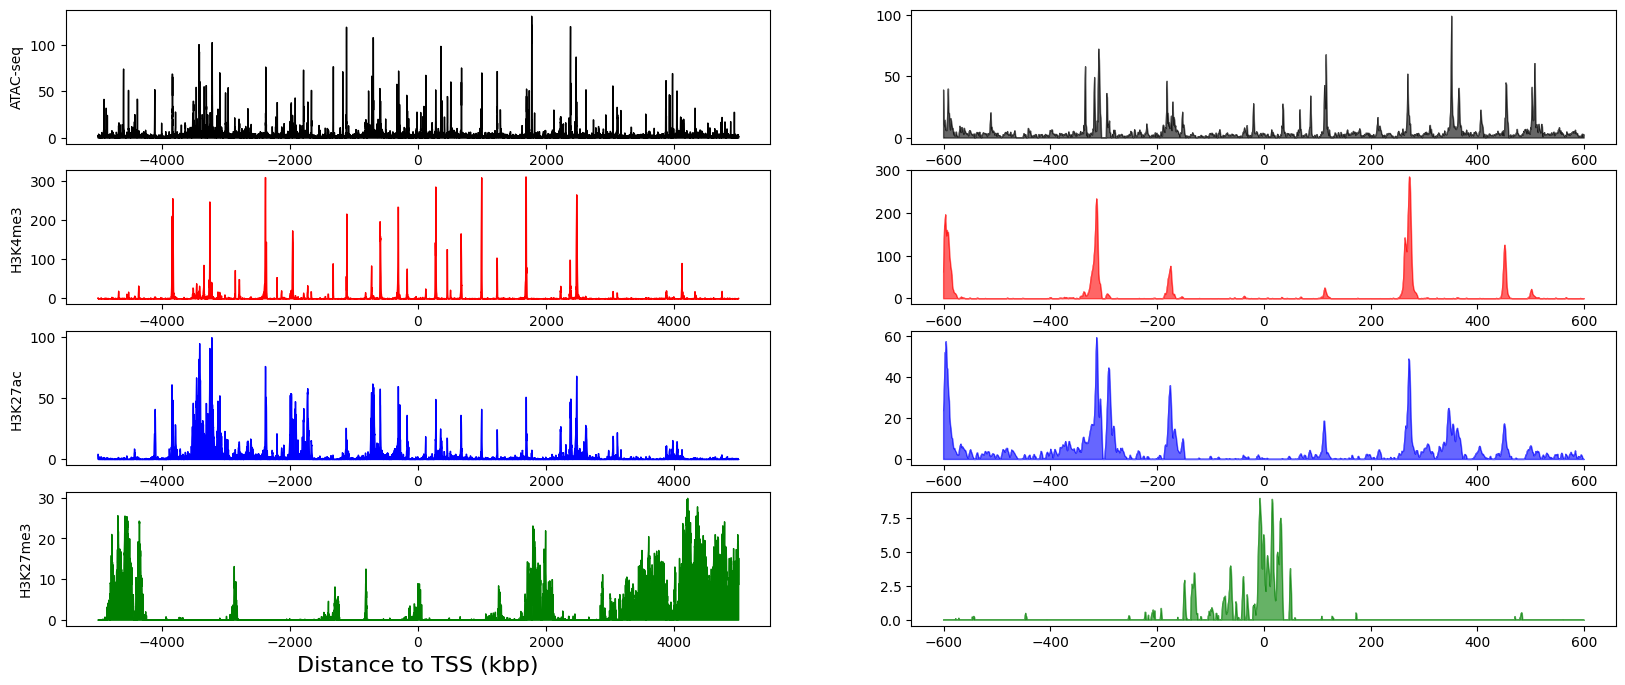

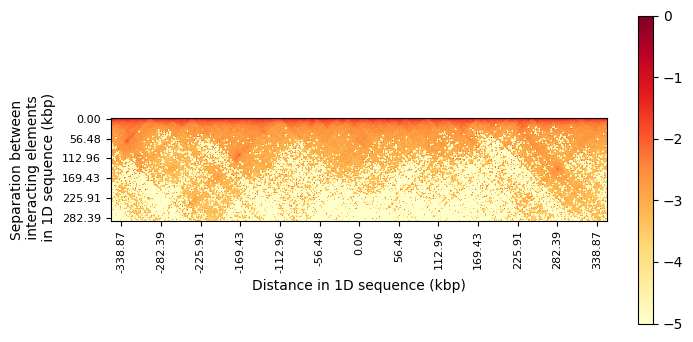

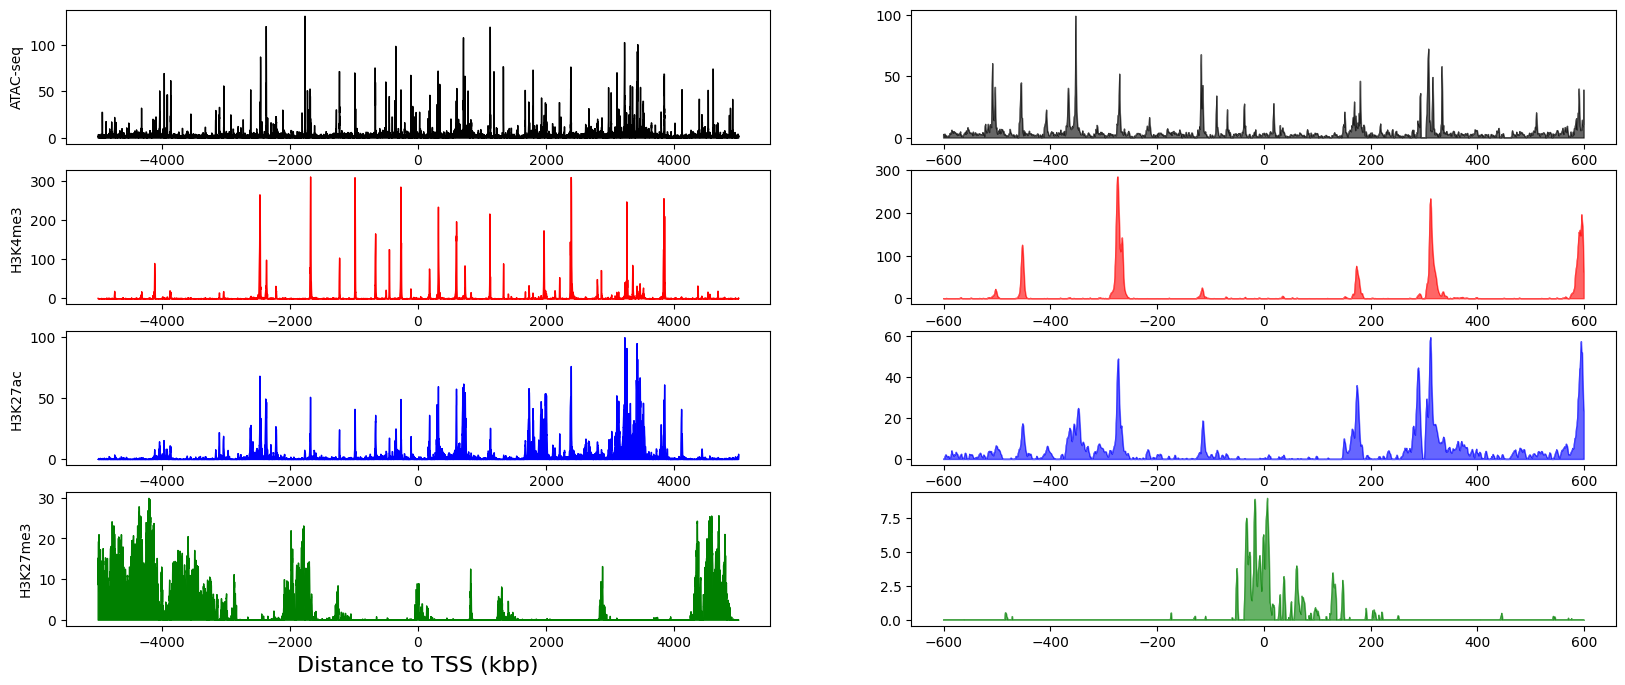

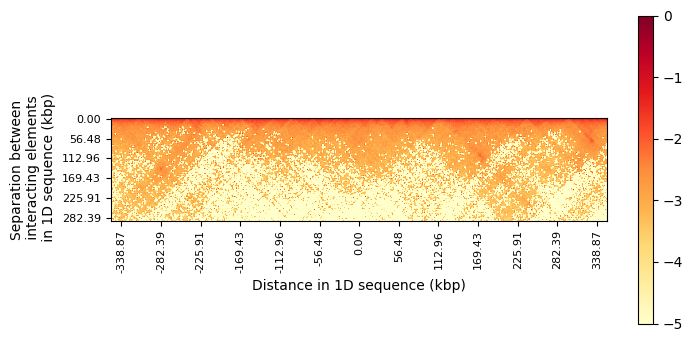

In [59]:
cropped_bins = 4400
scaling_factor = 1
track_dict = {0:{"name":"ATAC-seq","function":"Chromatin accessibility","color":"k"},
            1:{"name":"H3K4me3","function":"Promoter","color":"r"},
            2:{"name":"H3K27ac","function":"Enhancer","color":"b"},
            3:{"name":"H3K27me3","function":"Chromatin silencing","color":"g"}}

sample_name = "ENSMUSG00000000409.14" # "ENSMUSG00000000085.16"
pathlist = [Path('../inputs/microC_rotated/test/')]
num_bins = 626
window_of_observation = 707.10678118  # kbp (diagonal is not observing the same length in the genome.)

for orientation in ["forward","rev"]:
    landscape_array = np.load(f"../inputs/landscape_arrays/test/{sample_name}_{orientation}.npy")
    fig = visualize_input_array(landscape_array,
                     cropped_bins,
                     scaling_factor,
                     track_dict)
    fig.show()
    plot_microc_original_and_rotated(pathlist, num_bins, window_of_observation, name=f"{sample_name}_{orientation}.npy")


**Outputs:**

The goal of the network is to predict the nascent transcription levels matching the previous inputs. Nascent transcription was measured by EU-seq, reads were mapped to the reference mouse genome. The Reads were then binned in bins of 20bp and the obtained enrichment profiles were further smoothed and downsampled to obtain output profiles at a kbp resolution for the central 401 kbp.

In EIR, the outputs are provided as a csv file containing the sample ID and as many columns as targets we want to predict. 
You can now have a look at the targets for this tutorial, i.e EU-seq read counts per bin (1kbp) at a certain distance from the TSS of the gene of interest, the one naming each sample:

In [60]:
# Target csv file:
targets = pd.read_csv("../targets/test_targets.csv").set_index('ID')
targets

,-200_ctrl,-199_ctrl,-198_ctrl,-197_ctrl,-196_ctrl,-195_ctrl,-194_ctrl,-193_ctrl,-192_ctrl,-191_ctrl,...,191_ctrl,192_ctrl,193_ctrl,194_ctrl,195_ctrl,196_ctrl,197_ctrl,198_ctrl,199_ctrl,200_ctrl
ID,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000078673.10_forward,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000015,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000078673.10_rev,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000015,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000054885.11_forward,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.025029,0.004533,0.000326,0.000005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000054885.11_rev,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000005,0.000326,0.004533,0.025029,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000089773.7_forward,1.058536,1.002071,1.319272,1.858992,2.096323,2.060021,2.106640,2.085410,1.904420,1.915196,...,0.012807,0.033052,0.034374,0.014422,0.002805,0.004286,0.017631,0.030766,0.026285,1.039061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000017264.16_rev,0.000000,0.000000,0.000084,0.002141,0.020027,0.076142,0.120057,0.089212,0.064064,0.060956,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000023153.9_forward,5.779009,5.093278,4.074456,3.768673,3.827777,3.966342,4.429978,5.024314,5.499461,5.229515,...,5.473969,4.959192,4.670817,4.674260,4.714505,5.124657,5.729764,6.290256,6.755382,5.804558
ENSMUSG00000023153.9_rev,5.804558,6.755382,6.290256,5.729764,5.124657,4.714505,4.674260,4.670817,4.959192,5.473969,...,5.229515,5.499461,5.024314,4.429978,3.966342,3.827777,3.768673,4.074456,5.093278,5.779009


The final profiles look like this:

Orientation: forward
Orientation: rev


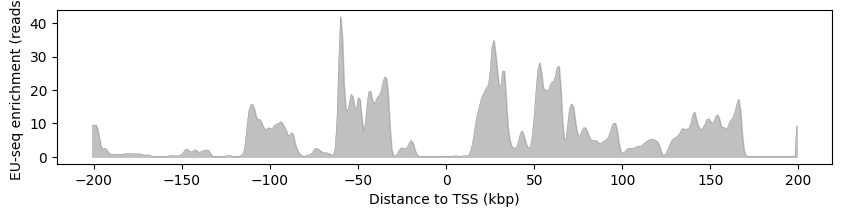

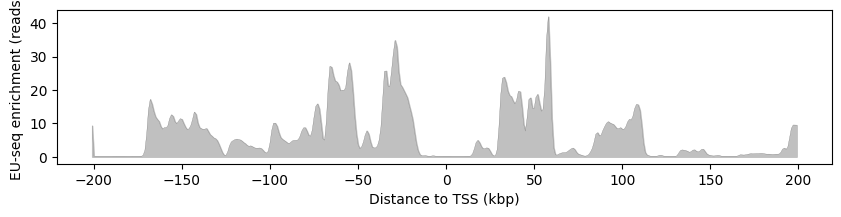

In [64]:
# Target profiles
sample_name = "ENSMUSG00000000409.14" 
for orientation in ["forward","rev"]:
    target_profile = targets.loc[f"{sample_name}_{orientation}"]
    print(f"Orientation: {orientation}")
    fig = visualize_target_array(target_profile,scaling_factor=1)
    fig.show()

## 2. Training and validating CLASTER

In [15]:
epochs: int = 120

### 2.1 Create config files:
First we will create the config files required to train and validate CLASTER:

We will need:
- A global configuration file: this file describes a number of training hyperparameters, e.g. the device we want to use, number of epochs, learning rate...
- An input configuration file: contains the description of the input feature extractor, including number of layers and type. We'll have one for each branch of the model.
- A fusion configuration file: This file describes the type and number of layers we want to fuse our features.
- An output configuration file: It describes how do we want to link our hidden representations of each sample and our targets.

The following cell will create a folder with the configs. Have a look at the fields in each of them!
We will also create a folder for the results called runs_tutorial.

In [5]:
# Create folder to store configuration files
config_paths = [Path("../configurations/conf_microc_rotated_pure_conv_tutorial/")]
for config_path in config_paths:
  config_path.mkdir(parents=True, exist_ok=True)

# Create folder to store results:
output_path = Path("../runs_tutorial/")
output_path.mkdir(parents=True, exist_ok=True)

# Write config files explicitly:
training_microc_rotated_yaml_contents = {"globals.yaml": f"""
output_folder: ../runs_tutorial/gene_expression_microc_rotated_pure_conv_tutorial/ 
checkpoint_interval: {int(860 /120 * epochs)}
sample_interval: {int(860 /120 * epochs)} 
n_epochs: {epochs}
batch_size: 64
optimizer: "adamw"
lr: 0.0001 
device: "cpu"
compute_attributions: false
# latent_sampling: 
#   layers_to_sample:
#     - "input_modules.contact_maps.feature_extractor.conv.0.conv_1"
#     - "input_modules.contact_maps.feature_extractor.conv.1.conv_2"
#     - "input_modules.contact_maps.feature_extractor.conv.1.conv_2"
""",
"input_cnn.yaml": """ 
input_info:
  input_source: ../inputs/landscape_arrays/test/ 
  input_name: gene_expression
  input_type: array

model_config:
  model_type: cnn
  #pre_normalization: "instancenorm"
  model_init_config:
    num_output_features: 512 # before fc_repr_dim
    layers: [4,4]
    kernel_height: 1
    down_stride_width: 2
    first_stride_expansion_width: 1
    first_kernel_expansion_height: 4 #5
    kernel_width: 10  #10
    dilation_factor_width: 2
    dilation_factor_height: 1
    channel_exp_base: 5  #3 #-1
    first_channel_expansion: 2
    rb_do: .3
    stochastic_depth_p: .1
    attention_inclusion_cutoff: 1 #50 #256

""",
"""input_cnn_microc_rotated.yaml""": """ 
input_info:
  input_source: ../inputs/microC_rotated/test/ #arrays_train_100bp_no_H3K27ac_uncoupled/
  input_name: contact_maps
  input_type: array

model_config:
  model_type: cnn
  #pre_normalization: "instancenorm"
  model_init_config:
    num_output_features: 512 #before fc_repr_dim
    layers: [1,2]
    kernel_height: 1
    down_stride_width: 2
    first_stride_expansion_width: 1
    first_kernel_expansion_height: 129 #Height of the array
    kernel_width: 10  #10
    dilation_factor_width: 2
    channel_exp_base: 4  #3 #-1
    first_channel_expansion: 2
    rb_do: .3
    stochastic_depth_p: .1
    attention_inclusion_cutoff: 1 # 50 #128 #256
""",
"fusion.yaml": """
model_config:
  fc_do: 0.4
  fc_task_dim: 256
  layers:
  - 2
  rb_do: 0.4
  stochastic_depth_p: 0.5
model_type: "mlp-residual"
""",
"outputs.yaml":"""
output_info:
  output_name: expression_output
  output_source: ../targets/test_targets.csv 
  output_type: tabular

model_config: # <- new
  model_type: linear # <- new

output_type_info:
  con_loss_name: "SmoothL1Loss"
  target_con_columns:
  - "-200_ctrl"
  - "-199_ctrl"
  - "-198_ctrl"
  - "-197_ctrl"
  - "-196_ctrl"
  - "-195_ctrl"
  - "-194_ctrl"
  - "-193_ctrl"
  - "-192_ctrl"
  - "-191_ctrl"
  - "-190_ctrl"
  - "-189_ctrl"
  - "-188_ctrl"
  - "-187_ctrl"
  - "-186_ctrl"
  - "-185_ctrl"
  - "-184_ctrl"
  - "-183_ctrl"
  - "-182_ctrl"
  - "-181_ctrl"
  - "-180_ctrl"
  - "-179_ctrl"
  - "-178_ctrl"
  - "-177_ctrl"
  - "-176_ctrl"
  - "-175_ctrl"
  - "-174_ctrl"
  - "-173_ctrl"
  - "-172_ctrl"
  - "-171_ctrl"
  - "-170_ctrl"
  - "-169_ctrl"
  - "-168_ctrl"
  - "-167_ctrl"
  - "-166_ctrl"
  - "-165_ctrl"
  - "-164_ctrl"
  - "-163_ctrl"
  - "-162_ctrl"
  - "-161_ctrl"
  - "-160_ctrl"
  - "-159_ctrl"
  - "-158_ctrl"
  - "-157_ctrl"
  - "-156_ctrl"
  - "-155_ctrl"
  - "-154_ctrl"
  - "-153_ctrl"
  - "-152_ctrl"
  - "-151_ctrl"
  - "-150_ctrl"
  - "-149_ctrl"
  - "-148_ctrl"
  - "-147_ctrl"
  - "-146_ctrl"
  - "-145_ctrl"
  - "-144_ctrl"
  - "-143_ctrl"
  - "-142_ctrl"
  - "-141_ctrl"
  - "-140_ctrl"
  - "-139_ctrl"
  - "-138_ctrl"
  - "-137_ctrl"
  - "-136_ctrl"
  - "-135_ctrl"
  - "-134_ctrl"
  - "-133_ctrl"
  - "-132_ctrl"
  - "-131_ctrl"
  - "-130_ctrl"
  - "-129_ctrl"
  - "-128_ctrl"
  - "-127_ctrl"
  - "-126_ctrl"
  - "-125_ctrl"
  - "-124_ctrl"
  - "-123_ctrl"
  - "-122_ctrl"
  - "-121_ctrl"
  - "-120_ctrl"
  - "-119_ctrl"
  - "-118_ctrl"
  - "-117_ctrl"
  - "-116_ctrl"
  - "-115_ctrl"
  - "-114_ctrl"
  - "-113_ctrl"
  - "-112_ctrl"
  - "-111_ctrl"
  - "-110_ctrl"
  - "-109_ctrl"
  - "-108_ctrl"
  - "-107_ctrl"
  - "-106_ctrl"
  - "-105_ctrl"
  - "-104_ctrl"
  - "-103_ctrl"
  - "-102_ctrl"
  - "-101_ctrl"
  - "-100_ctrl"
  - "-99_ctrl"
  - "-98_ctrl"
  - "-97_ctrl"
  - "-96_ctrl"
  - "-95_ctrl"
  - "-94_ctrl"
  - "-93_ctrl"
  - "-92_ctrl"
  - "-91_ctrl"
  - "-90_ctrl"
  - "-89_ctrl"
  - "-88_ctrl"
  - "-87_ctrl"
  - "-86_ctrl"
  - "-85_ctrl"
  - "-84_ctrl"
  - "-83_ctrl"
  - "-82_ctrl"
  - "-81_ctrl"
  - "-80_ctrl"
  - "-79_ctrl"
  - "-78_ctrl"
  - "-77_ctrl"
  - "-76_ctrl"
  - "-75_ctrl"
  - "-74_ctrl"
  - "-73_ctrl"
  - "-72_ctrl"
  - "-71_ctrl"
  - "-70_ctrl"
  - "-69_ctrl"
  - "-68_ctrl"
  - "-67_ctrl"
  - "-66_ctrl"
  - "-65_ctrl"
  - "-64_ctrl"
  - "-63_ctrl"
  - "-62_ctrl"
  - "-61_ctrl"
  - "-60_ctrl"
  - "-59_ctrl"
  - "-58_ctrl"
  - "-57_ctrl"
  - "-56_ctrl"
  - "-55_ctrl"
  - "-54_ctrl"
  - "-53_ctrl"
  - "-52_ctrl"
  - "-51_ctrl"
  - "-50_ctrl"
  - "-49_ctrl"
  - "-48_ctrl"
  - "-47_ctrl"
  - "-46_ctrl"
  - "-45_ctrl"
  - "-44_ctrl"
  - "-43_ctrl"
  - "-42_ctrl"
  - "-41_ctrl"
  - "-40_ctrl"
  - "-39_ctrl"
  - "-38_ctrl"
  - "-37_ctrl"
  - "-36_ctrl"
  - "-35_ctrl"
  - "-34_ctrl"
  - "-33_ctrl"
  - "-32_ctrl"
  - "-31_ctrl"
  - "-30_ctrl"
  - "-29_ctrl"
  - "-28_ctrl"
  - "-27_ctrl"
  - "-26_ctrl"
  - "-25_ctrl"
  - "-24_ctrl"
  - "-23_ctrl"
  - "-22_ctrl"
  - "-21_ctrl"
  - "-20_ctrl"
  - "-19_ctrl"
  - "-18_ctrl"
  - "-17_ctrl"
  - "-16_ctrl"
  - "-15_ctrl"
  - "-14_ctrl"
  - "-13_ctrl"
  - "-12_ctrl"
  - "-11_ctrl"
  - "-10_ctrl"
  - "-9_ctrl"
  - "-8_ctrl"
  - "-7_ctrl"
  - "-6_ctrl"
  - "-5_ctrl"
  - "-4_ctrl"
  - "-3_ctrl"
  - "-2_ctrl"
  - "-1_ctrl"
  - "0_ctrl"
  - "1_ctrl"
  - "2_ctrl"
  - "3_ctrl"
  - "4_ctrl"
  - "5_ctrl"
  - "6_ctrl"
  - "7_ctrl"
  - "8_ctrl"
  - "9_ctrl"
  - "10_ctrl"
  - "11_ctrl"
  - "12_ctrl"
  - "13_ctrl"
  - "14_ctrl"
  - "15_ctrl"
  - "16_ctrl"
  - "17_ctrl"
  - "18_ctrl"
  - "19_ctrl"
  - "20_ctrl"
  - "21_ctrl"
  - "22_ctrl"
  - "23_ctrl"
  - "24_ctrl"
  - "25_ctrl"
  - "26_ctrl"
  - "27_ctrl"
  - "28_ctrl"
  - "29_ctrl"
  - "30_ctrl"
  - "31_ctrl"
  - "32_ctrl"
  - "33_ctrl"
  - "34_ctrl"
  - "35_ctrl"
  - "36_ctrl"
  - "37_ctrl"
  - "38_ctrl"
  - "39_ctrl"
  - "40_ctrl"
  - "41_ctrl"
  - "42_ctrl"
  - "43_ctrl"
  - "44_ctrl"
  - "45_ctrl"
  - "46_ctrl"
  - "47_ctrl"
  - "48_ctrl"
  - "49_ctrl"
  - "50_ctrl"
  - "51_ctrl"
  - "52_ctrl"
  - "53_ctrl"
  - "54_ctrl"
  - "55_ctrl"
  - "56_ctrl"
  - "57_ctrl"
  - "58_ctrl"
  - "59_ctrl"
  - "60_ctrl"
  - "61_ctrl"
  - "62_ctrl"
  - "63_ctrl"
  - "64_ctrl"
  - "65_ctrl"
  - "66_ctrl"
  - "67_ctrl"
  - "68_ctrl"
  - "69_ctrl"
  - "70_ctrl"
  - "71_ctrl"
  - "72_ctrl"
  - "73_ctrl"
  - "74_ctrl"
  - "75_ctrl"
  - "76_ctrl"
  - "77_ctrl"
  - "78_ctrl"
  - "79_ctrl"
  - "80_ctrl"
  - "81_ctrl"
  - "82_ctrl"
  - "83_ctrl"
  - "84_ctrl"
  - "85_ctrl"
  - "86_ctrl"
  - "87_ctrl"
  - "88_ctrl"
  - "89_ctrl"
  - "90_ctrl"
  - "91_ctrl"
  - "92_ctrl"
  - "93_ctrl"
  - "94_ctrl"
  - "95_ctrl"
  - "96_ctrl"
  - "97_ctrl"
  - "98_ctrl"
  - "99_ctrl"
  - "100_ctrl"
  - "101_ctrl"
  - "102_ctrl"
  - "103_ctrl"
  - "104_ctrl"
  - "105_ctrl"
  - "106_ctrl"
  - "107_ctrl"
  - "108_ctrl"
  - "109_ctrl"
  - "110_ctrl"
  - "111_ctrl"
  - "112_ctrl"
  - "113_ctrl"
  - "114_ctrl"
  - "115_ctrl"
  - "116_ctrl"
  - "117_ctrl"
  - "118_ctrl"
  - "119_ctrl"
  - "120_ctrl"
  - "121_ctrl"
  - "122_ctrl"
  - "123_ctrl"
  - "124_ctrl"
  - "125_ctrl"
  - "126_ctrl"
  - "127_ctrl"
  - "128_ctrl"
  - "129_ctrl"
  - "130_ctrl"
  - "131_ctrl"
  - "132_ctrl"
  - "133_ctrl"
  - "134_ctrl"
  - "135_ctrl"
  - "136_ctrl"
  - "137_ctrl"
  - "138_ctrl"
  - "139_ctrl"
  - "140_ctrl"
  - "141_ctrl"
  - "142_ctrl"
  - "143_ctrl"
  - "144_ctrl"
  - "145_ctrl"
  - "146_ctrl"
  - "147_ctrl"
  - "148_ctrl"
  - "149_ctrl"
  - "150_ctrl"
  - "151_ctrl"
  - "152_ctrl"
  - "153_ctrl"
  - "154_ctrl"
  - "155_ctrl"
  - "156_ctrl"
  - "157_ctrl"
  - "158_ctrl"
  - "159_ctrl"
  - "160_ctrl"
  - "161_ctrl"
  - "162_ctrl"
  - "163_ctrl"
  - "164_ctrl"
  - "165_ctrl"
  - "166_ctrl"
  - "167_ctrl"
  - "168_ctrl"
  - "169_ctrl"
  - "170_ctrl"
  - "171_ctrl"
  - "172_ctrl"
  - "173_ctrl"
  - "174_ctrl"
  - "175_ctrl"
  - "176_ctrl"
  - "177_ctrl"
  - "178_ctrl"
  - "179_ctrl"
  - "180_ctrl"
  - "181_ctrl"
  - "182_ctrl"
  - "183_ctrl"
  - "184_ctrl"
  - "185_ctrl"
  - "186_ctrl"
  - "187_ctrl"
  - "188_ctrl"
  - "189_ctrl"
  - "190_ctrl"
  - "191_ctrl"
  - "192_ctrl"
  - "193_ctrl"
  - "194_ctrl"
  - "195_ctrl"
  - "196_ctrl"
  - "197_ctrl"
  - "198_ctrl"
  - "199_ctrl"
  - "200_ctrl"
  """
}

for file,content in training_microc_rotated_yaml_contents.items():
  with open(config_paths[0] / file, 'w') as f:
      f.write(content)

### 2.2 Run CLASTER:

> ⏰ *This step can take a while if we train for the recommended 120 epochs. To accelerate computations set the device to "cuda" or "mps" (for Mac) in the global config file, if you have access to a GPU.* 
>```python
>device: "cuda" # Alternatives are "mps" or "cpu"
>```
>*Otherwise, you can reduce the number of epochs by changing the following parameters in the global configs:*
>
>```python
>checkpoint_interval: 860
>sample_interval: 860 
>n_epochs: 120
>```
>
>*To* 
>
>```python
>checkpoint_interval: 72
>sample_interval: 72 
>n_epochs: 5
>```
>
>*This will highly compromise the performance of the model but will run faster. `checkpoint_interval` and `sample_interval` define at which batch number should we keep the results (model weights and predictions). We have 2590 samples and train in batches of 64 samples, which yields 36 batches per epoch. We can hence save the model every 72 batches (i.e. 2 epochs).* 


Run the following cell to train in a command-line fashion from this jupyter notebook.

In [ ]:
! eirtrain \
--global_configs ../configurations/conf_microc_rotated_pure_conv_tutorial/globals.yaml \
--input_configs ../configurations/conf_microc_rotated_pure_conv_tutorial/input_cnn.yaml ../configurations/conf_microc_rotated_pure_conv_tutorial/input_cnn_microc_rotated.yaml \
--fusion_configs ../configurations/conf_microc_rotated_pure_conv_tutorial/fusion.yaml \
--output_configs ../configurations/conf_microc_rotated_pure_conv_tutorial/outputs.yaml

### 2.3 Analyze results:

The previous code will generate a number of files and folders.
- Configs: a summary of the config files and complete description of model hyperparameters.
- Meta: eir version used (tested with eir 0.1.43).
- Results: predictions and true targets are given here for every batch we decided to store (e.g. 860). Performance plots per target node (e.g. -143_ctrl) are also provided here as csv and pdf files. Individual files per target node will be concatenated to yield predicted and target dataframes.
- Saved models: saved model weights.
- Serializations
- Tensorboard_logs
- A number of files including:
    - logging_history.log
    - model_info.txt: meta description of the model's architecture
    - training and validation history logs
    - *.pdf: performance curves

Now we will visualize the results by:
1) Plotting predicted vs True target values at a bin level (1kbp resolution).
2) Visualizing the predicted profiles.

In [22]:
#### Functions:
def _get_predictions(results_path: Path, N_BINS: int, condition_list: list, SPLIT: int):
    """
    This function reads the prediction files that EIR yields for each target (bin_condition, e.g. -150_ctrl) in the 
    training setting. Predictions are then converted into dataframes. 
    
    Args:
        results_path: path where the predictions are stored
        N_BINS: number of the bins to one side of the central bin (200 normally, 57 for the Enformer predictions).
        condition_list: list of conditions. As of now ["_ctrl"], but can be extended to other target conditions.
        SPLIT: The batch number we want to use for our visualization.
    Returns:
        ids: names of the samples
        predicted: predicted untransformed values 
        actual: actual values 
        
    """

    # Lists to store DataFrames for concatenation
    predicted_dfs = []
    actual_dfs = []

    for condition in condition_list:
        for i in range(-N_BINS, N_BINS + 1):
            file_path = results_path / f"expression_output/{i}{condition}/samples/{SPLIT}/regression_predictions.csv"
            predictions = pd.read_csv(file_path).set_index('ID')

            # Apply ReLU to model predictions
            predictions = predictions.clip(lower=0)

            # Prepare data for concatenation.
            predicted_column = predictions["Predicted"].rename(f"{i}{condition}")
            actual_column = predictions["Actual"].rename(f"{i}{condition}")

            predicted_dfs.append(predicted_column)
            actual_dfs.append(actual_column)

    # Concatenate all DataFrames horizontally
    predicted = pd.concat(predicted_dfs, axis=1)
    actual = pd.concat(actual_dfs, axis=1)
    ids = list(predicted.index)

    return ids, predicted, actual

def plot_target_predictions(line_p, line_a):
    """ 
    Plot the predicted and target EU-seq profiles. 
    Args:
        line_p: 1D numpy array containing the predicted values for the 401 output nodes
        line_a: "                           " ground truth "                         "

    Returns:
        fig: figure object to save or show.

    """
    fig, axs =plt.subplots(2, figsize=(8,4), sharex = True)
    axs[0].fill_between(np.arange(-200,201),line_p, lw=1, color='royalblue',alpha=.3, label="Predicted expression control")
    axs[1].fill_between(np.arange(-200,201),line_a, lw=1, color='silver', alpha=.6, label="Actual expression control")
    axs[1].set_xlabel("Distance from TSS (kbp)", fontsize=12)
    axs[1].set_ylabel('Reads')
    fig.legend(loc='upper center', ncols=2)   
    
    return fig

def plot_correlations(pred_list_values: list, actual_list_values: list, title: str, cmap: colors.Colormap = "afmhot", binlims: tuple = (0,50)):
    """ 
    This function plots predicted vs. actual values as a density map and provides the Spearman and Pearson correlations of the regressions. 

    Args:
        pred_list_values: list of predicted values flattened for all samples.
        actual_list_values: list of target values flattened for all samples.
        title: title of the plot
        cmap: colormap to visualize the density plot.
        binlims: limits of the bins

    Returns:
        fig: figure object to store or show.
    """
    # Get the counts histogram to plot correlation with density colormap
    counts, xedges, yedges = np.histogram2d(actual_list_values, pred_list_values, bins=[np.linspace(binlims[0],binlims[1],200),np.linspace(binlims[0],binlims[1],200)], density=False)
    
    # Plot regression of single predicted values vs. real
    pearson_r = pearsonr(actual_list_values,pred_list_values)[0]
    spearman_r = spearmanr(actual_list_values,pred_list_values)[0]
    m, b = np.polyfit(actual_list_values, pred_list_values, deg=1)
    # Actual fit:
    a1, a2, a3 = np.polyfit(actual_list_values, pred_list_values, deg=2)
    # Regression from origin:
    #m_0 , _, _, _ = np.linalg.lstsq(np.array(actual_list_values)[:,np.newaxis], pred_list_values) #x needs to be a column vector for this function

    # Create the figure
    fig, ax = plt.subplots(figsize=(4,4))    
    min_val, max_val, step = (0,10,.01)
    eps= 1
    # Counts matrix is transposed: the origin convention for plt.imshow is (top, left), for plt.hist2D is (bottom,left)
    counts[counts < eps] =1
    hist = ax.imshow(counts.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap=cmap,  norm=colors.LogNorm())
    _ = fig.colorbar(hist)
    _ = ax.axline(xy1=(0, b), slope=m, label=f'Linear fit:\n$ y = {m:.3f}x {b:+.3f}$\n$r_p:{pearson_r:.4f}$\n$r_s:{spearman_r:.4f}$', color="royalblue", ls="-", lw=1)
    #_ = ax.plot(np.arange(min_val,max_val,step), a1*(np.arange(min_val,max_val,step)**2)+a2*(np.arange(min_val,max_val,step))+a3, color='royalblue', ls = "--", lw=1, label= f"Polynomial fit:\n$y={a1:.3f}x^2+{a2:.3f}x+{a3:.3f}$")
    _ = ax.axis("scaled")
    _ = ax.set_xlim(min_val,max_val)
    _ = ax.set_ylim(min_val,max_val)
    _ = ax.set_xlabel("log$_2$(True +1)")
    _ = ax.set_ylabel("log$_2$(Predicted +1)")
    fig.legend(bbox_to_anchor=(.48,.8), fancybox=True, shadow=False, fontsize=7)

    return fig
    

We will now plot the overall validation performance (a fraction of samples are held out by default for validation). 
We will also plot the profiles for the sample centered around the gene Gm49337 (chr4, + strand).

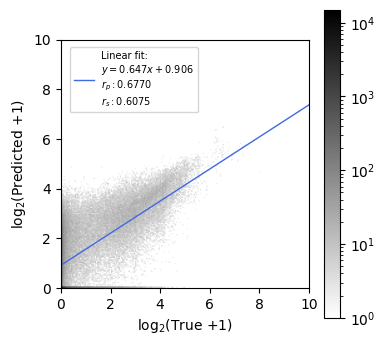

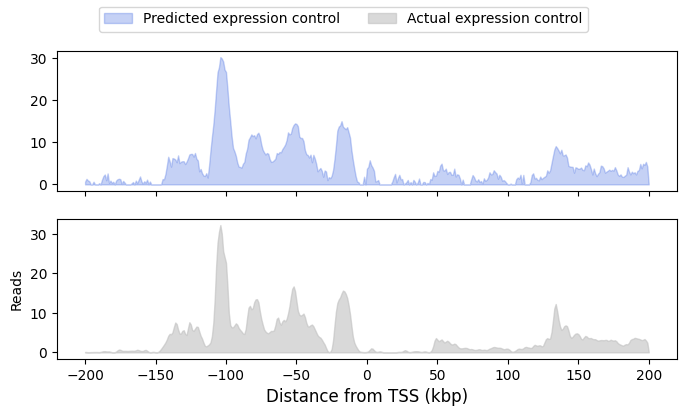

In [23]:
results_path = Path("../runs_tutorial/gene_expression_microc_rotated_pure_conv_tutorial/results/")
N_BINS= 200
condition_list = ["_ctrl"]
SPLIT = int(860 /120 * epochs)
# SPLIT = 4300 # for 860 samples, 120 epochs

ids, predicted, actual = _get_predictions(results_path, N_BINS, condition_list, SPLIT)


fig = plot_correlations(np.log2(predicted.values.flatten() + 1), np.log2(actual.values.flatten() +1 ), title= "Binwise Predicted vs True", cmap = "binary", binlims = (0,10))

for name in ['ENSMUSG00000111410.1_forward']:
    sample_name = name.split('_')[0]

    line_p = predicted.loc[f"{sample_name}_forward"].values
    line_a = actual.loc[f"{sample_name}_forward"].values

    fig = plot_target_predictions(line_p, line_a)
    fig.show()


## 3. Summary

Thanks for making it that far! We would like to end this tutorial with the following remark:

CLASTER was designed to predict nascent transcription, but the EIR framework can be reused and expanded for any other purpose. It can handle plenty of other data modalities as well! You just need a well defined input containing some information or signal that can be used to infer the values of another, as an output. You can then customize your network using EIR, provide the inputs and targets in one of the supported data modalities, and name samples with the same ID for input and output.

If in doubt, feel free to reach out to us!
